# Домашнее задание 5. Градиентный спуск. (10 баллов + 2.5 бонус)

В этом домашнем задании вы напишете градиентный спуск для линейной регрессии, а так же посмотрите, как он ведёт себя с разными параметрами и разными функциями потерь.

Правила:

* Домашнее задание оценивается в 10 баллов.

* Можно использовать без доказательства любые результаты, встречавшиеся на лекциях или семинарах по курсу, если получение этих результатов не является вопросом задания.

* Можно использовать любые свободные источники с *обязательным* указанием ссылки на них.

* Плагиат не допускается. При обнаружении случаев списывания, 0 за работу выставляется всем участникам нарушения, даже если можно установить, кто у кого списал.

* Старайтесь сделать код как можно более оптимальным. В частности, будет штрафоваться использование циклов в тех случаях, когда операцию можно совершить при помощи инструментов библиотек, о которых рассказывалось в курсе.  

In [182]:
from typing import List, Iterable

import numpy as np
import matplotlib.pyplot as plt

## Часть 1. Градиентный спуск (5 баллов)

Для начала давайте вспомним самый простой функционал ошибки, который мы применяем в задаче регрессии — Mean Squared Error:

$$
Q(w, X, y) = \frac{1}{\ell} \sum\limits_{i=1}^\ell (\langle x_i, w \rangle - y_i)^2
$$

где $x_i$ — это $i$-ый объект датасета, $y_i$ — правильный ответ для $i$-го объекта, а $w$ — веса нашей линейной модели.

Как мы помним, для линейной модели, его можно записать в матричном виде вот так:

$$
Q(w, X, y) = \frac{1}{\ell} || Xw - y ||^2
$$

где $X$ — это матрица объекты-признаки, а $y$ — вектор правильных ответов

Для того чтобы воспользоваться методом градиентного спуска, нам нужно посчитать градиент нашего функционала. Для MSE он будет выглядеть так:

$$
\nabla_w Q(w, X, y) = \frac{2}{\ell} X^T(Xw-y)
$$

Ниже приведён базовый класс `BaseLoss`, который мы будем использовать для реализации всех наших лоссов. Менять его не нужно. У него есть два абстрактных метода:
1. Метод `calc_loss`, который будет принимать на вход объекты `x`, правильные ответы `y` и веса `w` и вычислять значения лосса
2. Метод `calc_grad`, который будет принимать на вход объекты `x`, правильные ответы `y` и веса `w` и вычислять значения градиента (вектор)

In [183]:
import abc

class BaseLoss(abc.ABC):
    """Базовый класс лосса"""
    @abc.abstractmethod
    def calc_loss(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> float:
        """
        Функция для вычислений значения лосса
        :param X: np.ndarray размера (n_objects, n_features) с объектами датасета
        :param y: np.ndarray размера (n_objects,) с правильными ответами
        :param w: np.ndarray размера (n_features,) с весами линейной регрессии
        :return: число -- значения функции потерь
        """
        raise NotImplementedError

    @abc.abstractmethod
    def calc_grad(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> np.ndarray:
        """
        Функция для вычислений градиента лосса по весам w
        :param X: np.ndarray размера (n_objects, n_features) с объектами датасета
        :param y: np.ndarray размера (n_objects,) с правильными ответами
        :param w: np.ndarray размера (n_features,) с весами линейной регрессии
        :return: np.ndarray размера (n_features,) градиент функции потерь по весам w
        """
        raise NotImplementedError

Теперь давайте напишем реализацию этого абстрактоного класса: Mean Squared Error лосс.

### **Задание 1.1 (5/8 балла):** Реализуйте класс `MSELoss`

Он должен вычислять лосс и градиент по формулам наверху

In [184]:
class MSELoss(BaseLoss):

    def calc_loss(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> float:
        return np.linalg.norm(X @ w - y)**2 / y.shape[0]


    def calc_grad(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> np.ndarray:
        return 2 * X.T @ (X @ w - y) / y.shape[0]

Теперь мы можем создать объект `MSELoss` и при помощи него вычислять значение нашей функции потерь и градиенты:

In [185]:
# Создадим объект лосса
loss = MSELoss()

# Создадим какой-то датасет
X = np.arange(200).reshape(20, 10)
y = np.arange(20)

# Создадим какой-то вектор весов
w = np.arange(10)

# Выведем значение лосса и градиента на этом датасете с этим вектором весов
print(loss.calc_loss(X, y, w))
print(loss.calc_grad(X, y, w))

# Проверка, что методы реализованы правильно
assert loss.calc_loss(X, y, w) == 27410283.5, "Метод calc_loss реализован неверно"
assert np.allclose(loss.calc_grad(X, y, w), np.array([1163180., 1172281., 1181382., 1190483., 
                                                      1199584., 1208685., 1217786., 1226887., 
                                                      1235988., 1245089.])), "Метод calc_grad реализован неверно"
print("Всё верно!")

27410283.5
[1163180. 1172281. 1181382. 1190483. 1199584. 1208685. 1217786. 1226887.
 1235988. 1245089.]
Всё верно!


Теперь когда у нас есть всё для вычисления градиента, давайте напишем наш градиентный спуск. Напомним, что формула для одной итерации градиентного спуска выглядит следующим образом:

$$
w^t = w^{t-1} - \eta \nabla_{w} Q(w^{t-1}, X, y)
$$

Где $w^t$ — значение вектора весов на $t$-ой итерации, а $\eta$ — параметр learning rate, отвечающий за размер шага.

###**Задание 1.2 (5/8 балла):** Реализуйте функцию `gradient_descent`

Функция должна принимать на вход начальное значение весов линейной модели `w_init`, матрицу объектов-признаков `X`, 
вектор правильных ответов `y`, объект функции потерь `loss`, размер шага `lr` и количество итераций `n_iterations`.

Функция должна реализовывать цикл, в котором происходит шаг градиентного спуска (градиенты берутся из `loss` посредством вызова метода `calc_grad`) по формуле выше и возвращать 
траекторию спуска (список из новых значений весов на каждом шаге)

In [186]:
import copy

def gradient_descent(w_init: np.ndarray, X: np.ndarray, y: np.ndarray, 
                        loss: BaseLoss, lr: float, n_iterations: int = 1000000) -> List[np.ndarray]:
    """
    Функция градиентного спуска
    :param w_init: np.ndarray размера (n_feratures,) -- начальное значение вектора весов
    :param X: np.ndarray размера (n_objects, n_features) -- матрица объекты-признаки
    :param y: np.ndarray размера (n_objects,) -- вектор правильных ответов
    :param loss: Объект подкласса BaseLoss, который умеет считать градиенты при помощи loss.calc_grad(X, y, w)
    :param lr: float -- параметр величины шага, на который нужно домножать градиент
    :param n_iterations: int -- сколько итераций делать
    :return: Список из n_iterations объектов np.ndarray размера (n_features,) -- история весов на каждом шаге
    """
    trajectory = np.zeros((n_iterations + 1, w_init.shape[0]))
    trajectory[0] = copy.deepcopy(w_init)
    for i in range(1, n_iterations + 1):
        trajectory[i] = trajectory[i - 1] - loss.calc_grad(X=X, y=y, w=trajectory[i - 1]) * lr
  
    return trajectory


In [187]:
np.zeros((3, 2))

array([[0., 0.],
       [0., 0.],
       [0., 0.]])

Теперь создадим синтетический датасет и функцию, которая будет рисовать траекторию градиентного спуска по истории:

In [188]:
# Создаём датасет из двух переменных и реального вектора зависимости w_true

np.random.seed(1337)

n_features = 2
n_objects = 300
batch_size = 10
num_steps = 43

w_true = np.random.normal(size=(n_features, ))

X = np.random.uniform(-5, 5, (n_objects, n_features))
X *= (np.arange(n_features) * 2 + 1)[np.newaxis, :]  
y = X.dot(w_true) + np.random.normal(0, 1, (n_objects))
w_init = np.random.uniform(-2, 2, (n_features))

print(X.shape)
print(y.shape)

(300, 2)
(300,)


In [189]:
loss = MSELoss()
w_list = gradient_descent(w_init, X, y, loss, 0.01, 100)
print(w_list[0], w_list[50])
print(loss.calc_loss(X, y, w_list[0]))
print(loss.calc_loss(X, y, w_list[-1]))

[0.62074297 1.79288146] [-0.6677487  -0.48984875]
425.5891768045025
0.8670644395649494


In [190]:
def plot_gd(w_list: Iterable, X: np.ndarray, y: np.ndarray, loss: BaseLoss):
    """
    Функция для отрисовки траектории градиентного спуска
    :param w_list: Список из объектов np.ndarray размера (n_features,) -- история весов на каждом шаге
    :param X: np.ndarray размера (n_objects, n_features) -- матрица объекты-признаки
    :param y: np.ndarray размера (n_objects,) -- вектор правильных ответов
    :param loss: Объект подкласса BaseLoss, который умеет считать лосс при помощи loss.calc_loss(X, y, w)
    """
    w_list = np.array(w_list)
    meshgrid_space = np.linspace(-2, 2, 100)
    A, B = np.meshgrid(meshgrid_space, meshgrid_space)

    levels = np.empty_like(A)
    for i in range(A.shape[0]):
        for j in range(A.shape[1]):
            w_tmp = np.array([A[i, j], B[i, j]])
            levels[i, j] = loss.calc_loss(X, y, w_tmp)

    plt.figure(figsize=(35, 6))
    plt.title("GD trajectory")
    plt.xlabel(r'$w_1$')
    plt.ylabel(r'$w_2$')
    plt.xlim(w_list[:, 0].min() - 0.1, 
             w_list[:, 0].max() + 0.1)
    plt.ylim(w_list[:, 1].min() - 0.1,
             w_list[:, 1].max() + 0.1)
    plt.gca().set_aspect('equal')

    # visualize the level set
    CS = plt.contour(A, B, levels, levels=np.logspace(0, 1, num=20), cmap=plt.cm.rainbow_r)
    CB = plt.colorbar(CS, shrink=0.8, extend='both')

    # visualize trajectory
    plt.scatter(w_list[:, 0], w_list[:, 1])
    plt.plot(w_list[:, 0], w_list[:, 1])

    plt.show()

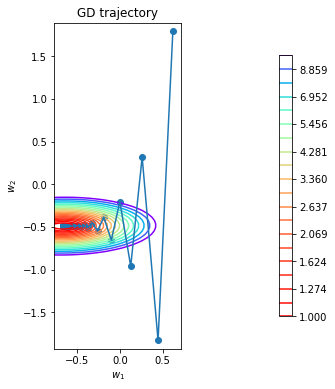

In [191]:
plot_gd(w_list, X, y, loss)

###**Задание 1.3 (5/8 балла):** 
При помощи функций `gradient_descent` и  `plot_gd` нарисуйте траекторию градиентного спуска для разных значений длины шага (параметра `lr`). Используйте не менее четырёх разных значений для `lr`. 

Сделайте и опишите свои выводы о том, как параметр `lr` влияет на поведение градиентного спуска

Подсказки:
* Функция `gradient_descent` возвращает историю весов, которую нужно подать в функцию `plot_gd`
* Хорошие значения для `lr` могут лежать в промежутке от 0.0001 до 0.1

In [192]:
weights = gradient_descent(w_init=w_init, X=X, y=y, loss=loss, lr=0.0001, n_iterations=100)
print(loss.calc_loss(X, y, weights[0]))
print(loss.calc_loss(X, y, weights[-1]))

425.5891768045025
27.07913862609387


In [193]:
weights = gradient_descent(w_init=w_init, X=X, y=y, loss=loss, lr=0.1, n_iterations=100)
print(loss.calc_loss(X, y, weights[0]))
print(loss.calc_loss(X, y, weights[-1]))

425.5891768045025
2.867494833868945e+237


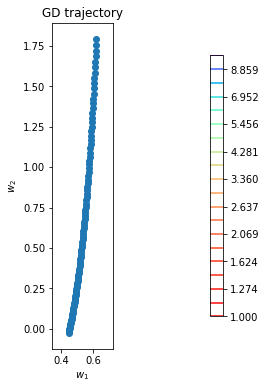

In [194]:
plot_gd(gradient_descent(w_init=w_init, X=X, y=y, loss=loss, lr=0.0001, n_iterations=100), X, y, loss)

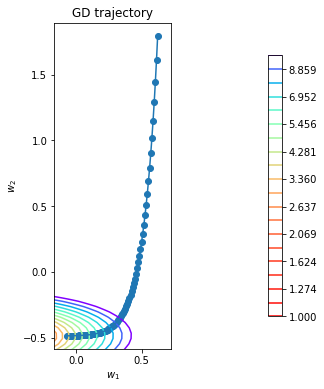

In [195]:
plot_gd(gradient_descent(w_init=w_init, X=X, y=y, loss=loss, lr=0.0005, n_iterations=100), X, y, loss)

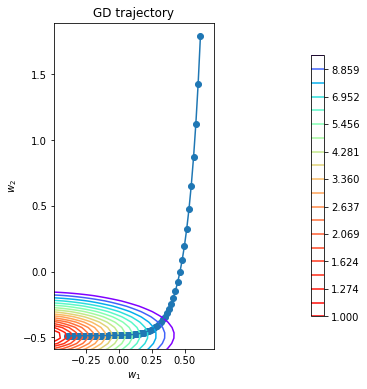

In [196]:
plot_gd(gradient_descent(w_init=w_init, X=X, y=y, loss=loss, lr=0.001, n_iterations=100), X, y, loss)

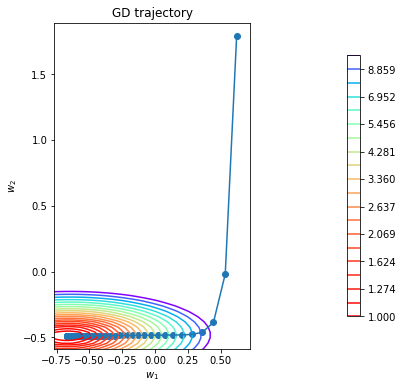

In [197]:
plot_gd(gradient_descent(w_init=w_init, X=X, y=y, loss=loss, lr=0.005, n_iterations=100), X, y, loss)

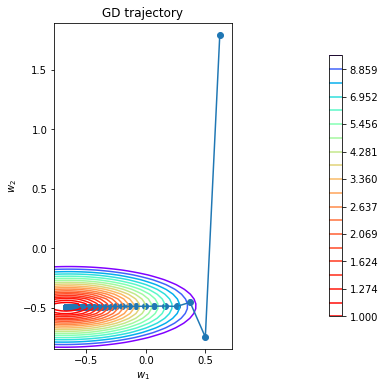

In [198]:
plot_gd(gradient_descent(w_init=w_init, X=X, y=y, loss=loss, lr=0.007, n_iterations=100), X, y, loss)

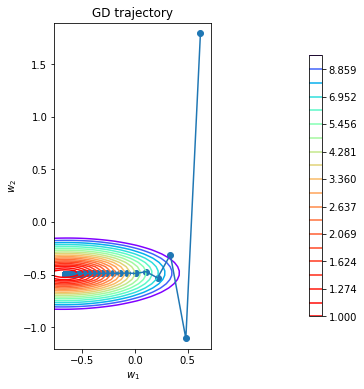

In [199]:
plot_gd(gradient_descent(w_init=w_init, X=X, y=y, loss=loss, lr=0.008, n_iterations=100), X, y, loss)

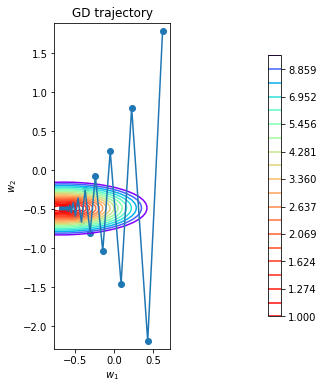

In [200]:
plot_gd(gradient_descent(w_init=w_init, X=X, y=y, loss=loss, lr=0.011, n_iterations=100), X, y, loss)

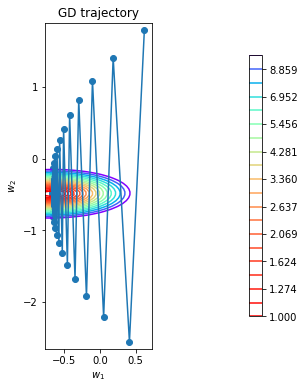

In [201]:
plot_gd(gradient_descent(w_init=w_init, X=X, y=y, loss=loss, lr=0.012, n_iterations=100), X, y, loss)

####Вывод: 
При увеличении шага модели, траектория спуска становиться молее ломаной, возможны колебания значения лосса, с уменьшением - она будет более гладкой, последовательной.

Теперь реализуем стохастический градиентный спуск

###**Задание 1.4 (5/8 балла):** Реализуйте функцию `stochastic_gradient_descent`

Функция должна принимать все те же параметры, что и функция `gradient_descent`, но ещё параметр `batch_size`, отвечающий за размер батча. 

Функция должна как и раньше реализовывать цикл, в котором происходит шаг градиентного спуска, но на каждом шаге считать градиент не по всей выборке `X`, а только по случайно выбранной части.

Подсказка: для выбора случайной части можно использовать [`np.random.choice`](https://numpy.org/doc/stable/reference/random/generated/numpy.random.choice.html) с правильным параметром `size`, чтобы выбрать случайные индексы, а потом проиндексировать получившимся массивом массив `X`:
```
batch_indices = np.random.choice(X.shape[0], size=batch_size, replace=False)
batch = X[batch_indices]
```

In [202]:
def stochastic_gradient_descent(w_init: np.ndarray, X: np.ndarray, y: np.ndarray, 
                        loss: BaseLoss, lr: float, batch_size: int, n_iterations: int = 1000) -> List[np.ndarray]:
    """
    Функция градиентного спуска
    :param w_init: np.ndarray размера (n_feratures,) -- начальное значение вектора весов
    :param X: np.ndarray размера (n_objects, n_features) -- матрица объекты-признаки
    :param y: np.ndarray размера (n_objects,) -- вектор правильных ответов
    :param loss: Объект подкласса BaseLoss, который умеет считать градиенты при помощи loss.calc_grad(X, y, w)
    :param lr: float -- параметр величины шага, на который нужно домножать градиент
    :param batch_size: int -- размер подвыборки, которую нужно семплировать на каждом шаге
    :param n_iterations: int -- сколько итераций делать
    :return: Список из n_iterations объектов np.ndarray размера (n_features,) -- история весов на каждом шаге
    """
    trajectory = np.zeros((n_iterations + 1, w_init.shape[0]))
    trajectory[0] = copy.copy(w_init)
    for i in range(1, n_iterations + 1):
        trajectory[i] = trajectory[i - 1] - lr * loss.calc_grad(X=X[np.random.choice(X.shape[0], size=batch_size, replace=False)], y=y[np.random.choice(X.shape[0], size=batch_size, replace=False)], w=trajectory[i - 1])
  
    return trajectory


###**Задание 1.5 (5/8 балла):** 
При помощи функций `stochastic_gradient_descent` и  `plot_gd` нарисуйте траекторию градиентного спуска для разных значений длины шага (параметра `lr`) и размера подвыборки (параметра `batch_size`). Используйте не менее четырёх разных значений для `lr` и `batch_size`. 

Сделайте и опишите свои выводы о том, как параметры  `lr` и `batch_size` влияют на поведение стохастического градиентного спуска. Как отличается поведение стохастического градиентного спуска от обычного?

Обратите внимание, что в нашем датасете всего 300 объектов, так что `batch_size` больше этого числа не будет иметь смысла.

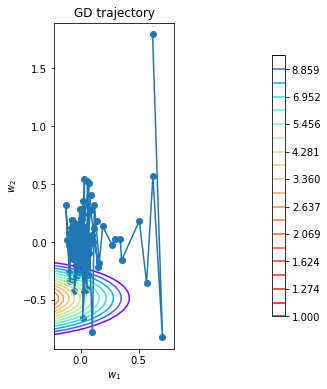

In [203]:
plot_gd(stochastic_gradient_descent(w_init=w_init, X=X, y=y, loss=loss, lr=0.011, n_iterations=100, batch_size=50), X, y, loss)

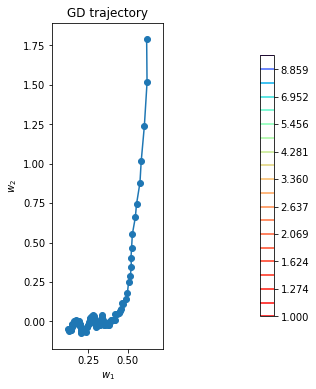

In [207]:
plot_gd(stochastic_gradient_descent(w_init=w_init, X=X, y=y, loss=loss, lr=0.001, n_iterations=100, batch_size=50), X, y, loss)

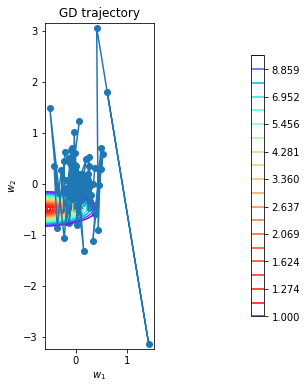

In [208]:
plot_gd(stochastic_gradient_descent(w_init=w_init, X=X, y=y, loss=loss, lr=0.011, n_iterations=100, batch_size=10), X, y, loss)

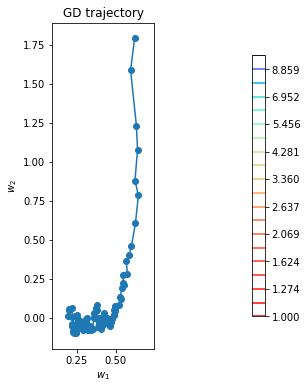

In [209]:
plot_gd(stochastic_gradient_descent(w_init=w_init, X=X, y=y, loss=loss, lr=0.001, n_iterations=100, batch_size=10), X, y, loss)

####Вывод:
Изменеие колличества изменений в выборке в десять раз не было заметно на графике, вот аналогичное уменьшение шага обучения превратило траекторию в сравнительно гладкую. 

Вы могли заметить, что поведение градиентного спуска, особенно стохастической версии, очень сильно зависит от размера шага. 

Как правило, в начале спуска мы хотим делать большие шаги, чтобы поскорее подойти поближе к минимуму, а позже мы уже хотим делать шаги маленькие, чтобы более точнее этого минимума достичь и не "перепрыгнуть" его. 

Чтобы достичь такого поведения мы можем постепенно уменьшать длину шага с увеличением номера итерации. Сделать это можно, например, вычисляя на каждой итерации длину шага по следующей формуле:

$$
    \eta_t
    =
    \lambda
    \left(
        \frac{s_0}{s_0 + t}
    \right)^p
$$

где $\eta_t$ — длина шага на итерации $t$, $\lambda$ — начальная длина шага (параметр `lr` у нас), $s_0$ и $p$ — настраиваемые параметры.

###**Задание 1.6 (5/8 балла):**
 Реализуйте функцию `stochastic_gradient_descent` на этот раз с затухающим шагом по формуле выше. Параметр $s_0$ возьмите равным 1. Параметр $p$ возьмите из нового аргумента функции `p`.

In [210]:
def stochastic_gradient_descent(w_init: np.ndarray, X: np.ndarray, y: np.ndarray, 
                        loss: BaseLoss, lr: float, batch_size: int, p: float, n_iterations: int = 1000) -> List[np.ndarray]:
    """
    Функция градиентного спуска
    :param w_init: np.ndarray размера (n_feratures,) -- начальное значение вектора весов
    :param X: np.ndarray размера (n_objects, n_features) -- матрица объекты-признаки
    :param y: np.ndarray размера (n_objects,) -- вектор правильных ответов
    :param loss: Объект подкласса BaseLoss, который умеет считать градиенты при помощи loss.calc_grad(X, y, w)
    :param lr: float -- параметр величины шага, на который нужно домножать градиент
    :param batch_size: int -- размер подвыборки, которую нужно семплировать на каждом шаге
    :param p: float -- значение степени в формуле затухания длины шага
    :param n_iterations: int -- сколько итераций делать
    :return: Список из n_iterations объектов np.ndarray размера (n_features,) -- история весов на каждом шаге
    """
    trajectory = np.zeros((n_iterations + 1, w_init.shape[0]))
    trajectory[0] = copy.copy(w_init)
    for i in range(1, n_iterations + 1):
        n = lr * (1 / (1 + i)) ** p
        trajectory[i] = trajectory[i - 1] - n * loss.calc_grad(X=X[np.random.choice(X.shape[0], size=batch_size, replace=False)], y=y[np.random.choice(X.shape[0], size=batch_size, replace=False)], w=trajectory[i - 1])
  
    return trajectory

###**Задание 1.7 (5/8 балла):** 
При помощи новой функции `stochastic_gradient_descent` и функции `plot_gd` нарисуйте траекторию градиентного спуска для разных значений параметра `p`. Используйте не менее четырёх разных значений для `p`. Хорошими могут быть значения, лежащие в промежутке от 0.1 до 1.
Параметр `lr` возьмите равным 0.01, а параметр `batch_size` равным 10.

Сделайте и опишите свои выводы о том, как параметр `p` влияет на поведение стохастического градиентного спуска

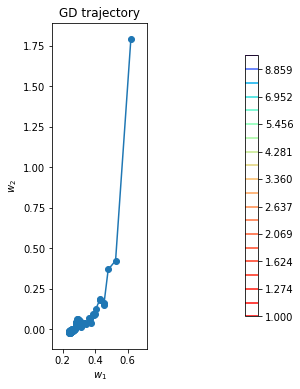

(None,)

In [211]:
lr = 0.01
batch_size = 10
n_itertations = 100
p = 1

plot_gd(stochastic_gradient_descent(w_init=w_init, X=X, y=y, loss=loss, lr=lr, n_iterations=n_itertations, batch_size=batch_size, p=p), X, y, loss), 

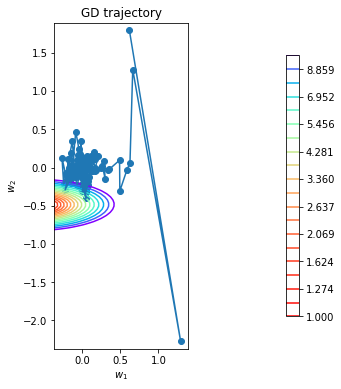

(None,)

In [149]:
lr = 0.01
batch_size = 10
n_itertations = 100
p = 0.139

plot_gd(stochastic_gradient_descent(w_init=w_init, X=X, y=y, loss=loss, lr=lr, n_iterations=n_itertations, batch_size=batch_size, p=p), X, y, loss), 

In [148]:
lr = 0.01
batch_size = 10
n_itertations = 100
p = 0.1

plot_gd(stochastic_gradient_descent(w_init=w_init, X=X, y=y, loss=loss, lr=lr, n_iterations=n_itertations, batch_size=batch_size, p=p), X, y, loss), 

(None,)

####Вывод:
При уменьшении p траектория становиться более ломаной, что неудивительно так как шаг убывает медленнее.

###**Задание 1.8 (5/8 балла):** 
Сравните сходимость обычного градиентного спуска и стохастичекой версии:
Нарисуйте график зависимости значения лосса (его можно посчитать при помощи метода `calc_loss`, используя $x$ и $y$ из датасета и $w$ с соответствующей итерации) от номера итерации для траекторий, полученных при помощи обычного и стохастического градиентного спуска с одинаковыми параметрами. Параметр `batch_size` возьмите равным 10.

Видно ли на данном графике преимущество SGD? Почему?

Text(0.5, 0, 'iteration')

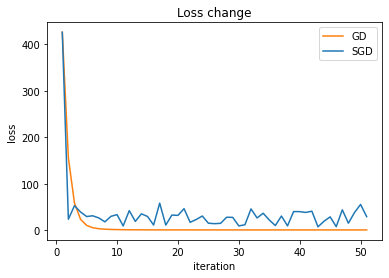

In [150]:
def calc_loss_path(trajectory: np.ndarray, X: np.ndarray, y: np.ndarray, 
                        loss: BaseLoss):
    return [loss.calc_loss(X, y, trajectory[i]) for i in range(trajectory.shape[0])]




loss = MSELoss()
lr = 0.01
n_itertations = 50
batch_size = 10

SGD_tr = stochastic_gradient_descent(w_init=w_init, X=X, y=y, loss=loss, lr=lr, n_iterations=n_itertations, batch_size=batch_size, p=p)
GD_tr = gradient_descent(w_init=w_init, X=X, y=y, loss=loss, lr=lr, n_iterations=n_itertations)

calc_loss_path(SGD_tr, X, y, loss)

fig, ax = plt.subplots()

plt.title('Loss change')
ax.plot(range(1, GD_tr.shape[0] + 1), calc_loss_path(GD_tr, X, y, loss), color='C1', label='GD')
ax.plot(range(1, SGD_tr.shape[0] + 1), calc_loss_path(SGD_tr, X, y, loss), label='SGD')
plt.legend()
plt.ylabel('loss')
plt.xlabel('iteration')


#### Вывод: ####
Преимущество стохастического градиентного спуска незаментно (более того, он не сходится), так как пока у нас мало объектов, а выигрыш стохастического градиенного спуска в возможности сократить колличество операций.

## Часть 2. Линейная регрессия (5 баллов)

Теперь давайте напишем наш класс для линейной регрессии. Он будет использовать интерфейс, знакомый нам из библиотеки `sklearn`.

В методе `fit` мы будем подбирать веса `w` при помощи градиентного спуска нашим методом `gradient_descent`

В методе `predict` мы будем применять нашу регрессию к датасету, 

###**Задание 2.1 (5/8 балла):** 
Допишите код в методах `fit` и `predict` класса `LinearRegression`

В методе `fit` вам нужно как-то инициализировать веса `w`, применить `gradient_descent` и сохранить последнюю `w` из траектории.

В методе `predict` вам нужно применить линейную регрессию и вернуть вектор ответов.

Обратите внимание, что объект лосса передаётся в момент инициализации и хранится в `self.loss`. Его нужно использовать в `fit` для `gradient_descent`.

In [151]:
class LinearRegression:
    def __init__(self, loss: BaseLoss, lr: float = 0.001) -> None:
        self.loss = loss
        self.lr = lr
    
    def fit(self, X: np.ndarray, y: np.ndarray) -> 'LinearRegression':
        X = np.asarray(X)
        y = np.asarray(y)
        # Добавляем столбец из единиц для константного признака
        X = np.hstack([X, np.ones([X.shape[0], 1])])
        w_init = np.random.uniform(-2, 2, (X.shape[1]))
        w = gradient_descent(w_init=w_init, X=X, y=y, lr=self.lr, loss=self.loss)
        self.w = w[-1]
        return self
    
    def predict(self, X: np.ndarray) -> np.ndarray:
        # Проверяем, что регрессия обучена, то есть, что был вызван fit и в нём был установлен атрибут self.w
        assert hasattr(self, "w"), "Linear regression must be fitted first"
        # Добавляем столбец из единиц для константного признака
        X = np.hstack([X, np.ones([X.shape[0], 1])])
        return X @ self.w
        


Теперь у нас есть наш класс линейной регрессии. Более того, мы можем управлять тем, какую функцию потерь мы оптимизируем, просто передавая разные классы в параметр `loss` при инициализации. 

Пока у нас нет никаких классов кроме `MSELoss`, но скоро они появятся.

Для `MSELoss` мы бы создавали наш объект линейной регрессии, например, так:

In [152]:
linear_regression = LinearRegression(MSELoss())

Применим нашу регрессию на реальном датасете. Загрузим датасет с машинами, который был у вас на семинарах:

In [153]:
import pandas as pd

X_raw = pd.read_csv(
    "http://archive.ics.uci.edu/ml/machine-learning-databases/autos/imports-85.data", 
    header=None, 
    na_values=["?"]
)
X_raw.head()
X_raw = X_raw[~X_raw[25].isna()].reset_index()

###**Задание 2.2 (5/8 балла):**
 Как обычно обработайте датасет всеми нужными методами, чтобы на нём можно было обучать линейную регрессию:

* Разделите датасет на обучающую и тестовую выборку
* Заполните пропуски
* Нормализуйте числовые признаки
* Закодируйте категориальные переменные

In [154]:
X_raw

index  0      1            2       3  ...     21      22  23  24       25
0        0  3    NaN  alfa-romero     gas  ...  111.0  5000.0  21  27  13495.0
1        1  3    NaN  alfa-romero     gas  ...  111.0  5000.0  21  27  16500.0
2        2  1    NaN  alfa-romero     gas  ...  154.0  5000.0  19  26  16500.0
3        3  2  164.0         audi     gas  ...  102.0  5500.0  24  30  13950.0
4        4  2  164.0         audi     gas  ...  115.0  5500.0  18  22  17450.0
..     ... ..    ...          ...     ...  ...    ...     ...  ..  ..      ...
196    200 -1   95.0        volvo     gas  ...  114.0  5400.0  23  28  16845.0
197    201 -1   95.0        volvo     gas  ...  160.0  5300.0  19  25  19045.0
198    202 -1   95.0        volvo     gas  ...  134.0  5500.0  18  23  21485.0
199    203 -1   95.0        volvo  diesel  ...  106.0  4800.0  26  27  22470.0
200    204 -1   95.0        volvo     gas  ...  114.0  5400.0  19  25  22625.0

[201 rows x 27 columns]

Похоже, что столбцы 5 и 15 - написанные прописью числа, проверим:

In [155]:
X_prep = X_raw.drop('index', axis=1)

In [156]:
X_prep.describe(include='object')

2    3    4     5      6    7      8    14    15    17
count      201  201  201   199    201  201    201  201   201   201
unique      22    2    2     2      5    3      2    6     7     8
top     toyota  gas  std  four  sedan  fwd  front  ohc  four  mpfi
freq        32  181  165   113     94  118    198  145   157    92

In [157]:
X_prep.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 201 entries, 0 to 200
Data columns (total 26 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       201 non-null    int64  
 1   1       164 non-null    float64
 2   2       201 non-null    object 
 3   3       201 non-null    object 
 4   4       201 non-null    object 
 5   5       199 non-null    object 
 6   6       201 non-null    object 
 7   7       201 non-null    object 
 8   8       201 non-null    object 
 9   9       201 non-null    float64
 10  10      201 non-null    float64
 11  11      201 non-null    float64
 12  12      201 non-null    float64
 13  13      201 non-null    int64  
 14  14      201 non-null    object 
 15  15      201 non-null    object 
 16  16      201 non-null    int64  
 17  17      201 non-null    object 
 18  18      197 non-null    float64
 19  19      197 non-null    float64
 20  20      201 non-null    float64
 21  21      199 non-null    float64
 22  22

####Вывод:
В столбцах 1, 5, 18, 19, 21, 22 есть пропуски, их нужно заполнить. Используем средние значения для всех кроме 5 - тип не подходит

In [158]:
for col in [1, 18, 19, 21, 22]:
  X_prep[col].fillna(X_prep[col].median(), inplace=True)

X_prep.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 201 entries, 0 to 200
Data columns (total 26 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       201 non-null    int64  
 1   1       201 non-null    float64
 2   2       201 non-null    object 
 3   3       201 non-null    object 
 4   4       201 non-null    object 
 5   5       199 non-null    object 
 6   6       201 non-null    object 
 7   7       201 non-null    object 
 8   8       201 non-null    object 
 9   9       201 non-null    float64
 10  10      201 non-null    float64
 11  11      201 non-null    float64
 12  12      201 non-null    float64
 13  13      201 non-null    int64  
 14  14      201 non-null    object 
 15  15      201 non-null    object 
 16  16      201 non-null    int64  
 17  17      201 non-null    object 
 18  18      201 non-null    float64
 19  19      201 non-null    float64
 20  20      201 non-null    float64
 21  21      201 non-null    float64
 22  22

In [159]:
X_prep.dropna(inplace=True)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe20666a110>,
      dtype=object)

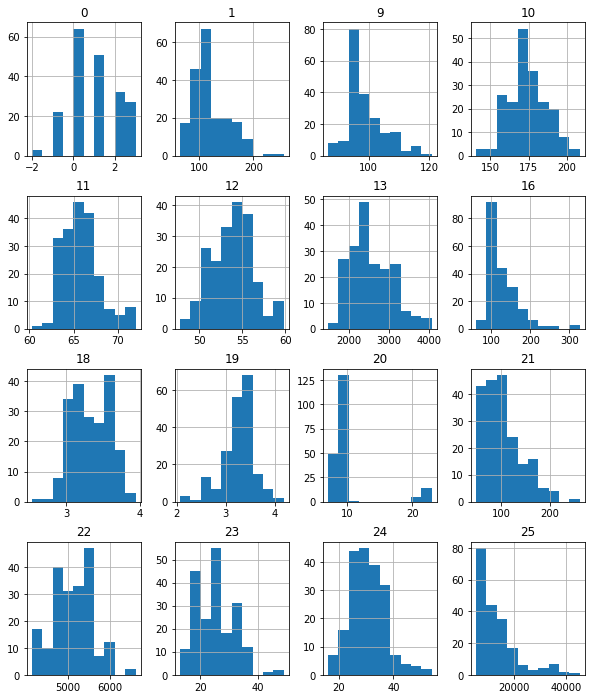

In [160]:
X_prep.hist(figsize=(10, 12))

In [161]:
y = X_prep[25]
X_prep = X_prep.drop(25, axis=1)

In [162]:
{c:X_prep[c].unique() for c in X_prep.select_dtypes('object').columns}

{2: array(['alfa-romero', 'audi', 'bmw', 'chevrolet', 'dodge', 'honda',
        'isuzu', 'jaguar', 'mazda', 'mercedes-benz', 'mercury',
        'mitsubishi', 'nissan', 'peugot', 'plymouth', 'porsche', 'renault',
        'saab', 'subaru', 'toyota', 'volkswagen', 'volvo'], dtype=object),
 3: array(['gas', 'diesel'], dtype=object),
 4: array(['std', 'turbo'], dtype=object),
 5: array(['two', 'four'], dtype=object),
 6: array(['convertible', 'hatchback', 'sedan', 'wagon', 'hardtop'],
       dtype=object),
 7: array(['rwd', 'fwd', '4wd'], dtype=object),
 8: array(['front', 'rear'], dtype=object),
 14: array(['dohc', 'ohcv', 'ohc', 'l', 'rotor', 'ohcf'], dtype=object),
 15: array(['four', 'six', 'five', 'three', 'twelve', 'two', 'eight'],
       dtype=object),
 17: array(['mpfi', '2bbl', 'mfi', '1bbl', 'spfi', '4bbl', 'idi', 'spdi'],
       dtype=object)}

In [163]:
from sklearn.preprocessing import LabelEncoder
label = LabelEncoder()


X_prep[X_prep.select_dtypes('object').columns] = X_prep[X_prep.select_dtypes('object').columns].apply(LabelEncoder().fit_transform)
#X_prep = pd.get_dummies(X_prep, columns=X_prep.select_dtypes('object').columns.values)
X_prep.head()

0      1   2   3   4   5   6   ...    18    19    20     21      22  23  24
0   3  115.0   0   1   0   1   0  ...  3.47  2.68   9.0  111.0  5000.0  21  27
1   3  115.0   0   1   0   1   0  ...  3.47  2.68   9.0  111.0  5000.0  21  27
2   1  115.0   0   1   0   1   2  ...  2.68  3.47   9.0  154.0  5000.0  19  26
3   2  164.0   1   1   0   0   3  ...  3.19  3.40  10.0  102.0  5500.0  24  30
4   2  164.0   1   1   0   0   3  ...  3.19  3.40   8.0  115.0  5500.0  18  22

[5 rows x 25 columns]

In [164]:
from sklearn.model_selection import train_test_split

# Разбиваем выборку на тестовую и обучающую
X_train, X_test, y_train, y_test =  train_test_split(X_prep, y, test_size=0.3, random_state=42)

#### Вывод:
В целом, распределение числовых параметров напоминает нормальное, и хотя безусловно отдельные признаки (21, 24) ближе к f-распределению, всё же можно использовать StandartScaler

In [165]:
#Нормализуем числовые признаки 
from sklearn import preprocessing


normalizer = preprocessing.StandardScaler()
X_train, X_test = map(lambda x: pd.DataFrame(x, columns=X_train.columns), (normalizer.fit_transform(X_train), normalizer.fit_transform(X_test)))


In [166]:
X_train.head(10)

0         1         2   ...        22        23        24
0 -0.700561 -1.006663  0.928339  ... -0.632268  0.407817  0.155843
1  0.153632 -0.619770 -1.119901  ...  1.846282  0.732668  0.460944
2 -0.700561  2.185200 -1.592571  ... -1.768270 -0.729162 -0.454359
3 -0.700561 -0.458565 -1.119901  ...  1.433191  0.245391  0.308393
4  0.153632  1.089005  0.298111  ...  0.813553  0.895093  1.071146
5  1.007824 -0.168396 -0.962344  ... -0.219176 -0.241885 -0.301808
6  1.007824  1.314692 -0.174559  ...  0.813553  0.895093  1.071146
7 -0.700561 -0.587529  0.928339  ... -1.458452  0.407817  0.308393
8 -0.700561 -0.587529  0.928339  ... -0.632268  1.057519  0.918595
9  1.862017  0.960041 -0.647230  ...  1.846282 -1.378864 -1.217111

[10 rows x 25 columns]

###**Задание 2.3 (5/8 балла):** Обучите написанную вами линейную регрессию на обучающей выборке

In [167]:
linear_regression = LinearRegression(MSELoss())
linear_regression = linear_regression.fit(X_train, y_train)

In [168]:
linear_regression.w

array([ -149.54914987,    94.16847282, -1151.31840898,  7016.562694  ,
        1071.63611242,  -434.17569912,  -325.46305334,    40.49475416,
        1018.36713655,   335.57072086,  -749.566243  ,  1403.97458843,
         281.09597356,  1603.417057  ,  -464.38047175,   810.30354637,
        2583.5271941 ,   334.16955223,  -285.71170932,  -620.68576365,
        7249.58863985,   201.75249622,    17.02172007, -1668.16672327,
        1000.99921184, 12236.26618705])

#### Комментарий:
Веса выглядят очень большими, похоже на то, что модель переобучилась.

### **Задание 2.4 (5/8 балла):** 
Посчитайте ошибку обученной регрессии на обучающей и тестовой выборке при помощи метода `mean_squared_error` из `sklearn.metrics`.

In [169]:
from sklearn.metrics import mean_squared_error

print(f'Ошибка на тестовой выборке {mean_squared_error(y_test, linear_regression.predict(X_test))}')
print(f'Ошибка на обучающей выборке {mean_squared_error(y_train, linear_regression.predict(X_train))}')
print(f'Ошибка на тестовой выборке в {round(mean_squared_error(y_test, linear_regression.predict(X_test)) / mean_squared_error(y_train, linear_regression.predict(X_train)))} раз больше, чем на тестовой')

Ошибка на тестовой выборке 45792905.84582244
Ошибка на обучающей выборке 4456836.855412178
Ошибка на тестовой выборке в 10 раз больше, чем на тестовой


Наша модель переобучилась. Давайте как обычно в такой ситуации добавим к ней L2 регуляризацию. Для этого нам нужно написать новый класс лосса.

Формула функции потерь для MSE с L2 регуляризацией выглядит так:
$$
Q(w, X, y) = \frac{1}{\ell} \sum\limits_{i=1}^\ell (\langle x_i, w \rangle - y_i)^2 + \lambda ||w||^2
$$

Или в матричном виде:

$$
Q(w, X, y) = \frac{1}{\ell} || Xw - y ||^2 + \lambda ||w||^2
$$

Где $\lambda$ — коэффициент регуляризации

Градиент выглядит так:

$$
\nabla_w Q(w, X, y) = \frac{2}{\ell} X^T(Xw-y) + 2 \lambda w
$$

### **Задание 2.5 (5/8 балла):** 
Реализуйте класс `MSEL2Loss`

Он должен вычислять лосс и градиент по формулам наверху

Подсказка: обратите внимание, что последний элемент вектора `w` — это bias (в классе `LinearRegression` к матрице `X` добавляется колонка из единиц — константный признак). Как мы знаем из лекций и семинаров, bias регуляризовать не нужно. Поэтому не забудьте убрать последний элемент из `w` при подсчёте слагаемого $\lambda||w||^2$ в `calc_loss` и занулить его при подсчёте слагаемого $2 \lambda w$ в `calc_grad`

In [170]:
class MSEL2Loss(BaseLoss):
    def __init__(self, coef: float = 1.):
        """
        :param coef: коэффициент регуляризации (лямбда в формуле)
        """
        self.coef = coef
    
    def calc_loss(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> float:
        """
        Функция для вычислений значения лосса
        :param X: np.ndarray размера (n_objects, n_features) с объектами датасета. Последний признак константный.
        :param y: np.ndarray размера (n_objects,) с правильными ответами
        :param w: np.ndarray размера (n_features,) с весами линейной регрессии. Последний вес -- bias.
        :output: число -- значения функции потерь
        """
        return np.linalg.norm(X @ w - y)**2 / y.shape[0] + self.coef * np.linalg.norm(w[:-1]) ** 2
        
    def calc_grad(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> np.ndarray:
        """
        Функция для вычислений градиента лосса по весам w
        :param X: np.ndarray размера (n_objects, n_features) с объектами датасета
        :param y: np.ndarray размера (n_objects,) с правильными ответами
        :param w: np.ndarray размера (n_features,) с весами линейной регрессии
        :output: np.ndarray размера (n_features,) градиент функции потерь по весам w
        """
        return 2 * X.T @ (X @ w - y) / y.shape[0] + 2 * self.coef * np.array(list(w[:-1]) + [0])

Теперь мы можем использовать лосс с l2 регуляризацией в нашей регрессии, например, так:

In [171]:
linear_regression = LinearRegression(MSEL2Loss(0.1))

### **Задание 2.6 (5/8 балла):**
 Обучите регрессию с лоссом `MSEL2Loss`. Подберите хороший коэффициент регуляризации и добейтесь улучшения результата на тестовой выборке. Сравните результат на обучающей и тестовой выборке с регрессией без регуляризации. 

In [172]:
linear_regression = LinearRegression(MSEL2Loss(0.045))
linear_regression = linear_regression.fit(X_train, y_train)

In [173]:
linear_regression.w

array([-1.66360075e+00,  2.56894302e+01, -9.66935260e+02,  3.37924882e+02,
        3.21594334e+02, -4.26314968e+02, -4.77119065e+02,  2.22841591e+02,
        9.93961571e+02,  3.71851729e+02,  1.80025055e+02,  1.11658470e+03,
        2.65882966e+02,  1.19786198e+03, -2.58576460e+02,  7.03515099e+02,
        1.97957653e+03,  2.11785349e+02, -4.51267565e+02, -6.28446542e+02,
        8.98628524e+02,  1.00536032e+03,  1.39610679e+02, -3.30063271e+02,
        1.82893924e+02,  1.22362662e+04])

In [213]:
from sklearn.metrics import mean_squared_error

print('Первоначально разница была в 10 раз')
print(f'Стала в {round(mean_squared_error(y_test, linear_regression.predict(X_test)) / mean_squared_error(y_train, linear_regression.predict(X_train)))} раз')

Первоначально разница была в 10 раз
Стала в 8 раз


В нашем датасете могут быть выбросы. На семинаре вам рассказывали, что с выбросами хорошо помогает бороться Huber Loss. Вдали от нуля он работает как Mean Absolute Error и не реагирует на выбросы так сильно, как MSE. Давайте его реализуем и применим в нашей регрессии.

Напомним, что функция потерь Huber Loss'а  выглядит так:


$$
    Q(w, X, y) = \frac{1}{\ell} \sum\limits_{i=1}^\ell \phi_\varepsilon (\langle x_i, w \rangle - y_i)
$$
$$
    \phi_\varepsilon(z) = \begin{cases} \frac 1 2 z^2, - \varepsilon < z < \varepsilon, \\\varepsilon (|z| - \frac 1 2 \varepsilon), иначе \\ \end{cases}
$$


А градиент так:
$$
    \nabla_w Q(w, X, y) = \frac{1}{\ell} \sum\limits_{i=1}^\ell x_i \nabla_z \phi_\varepsilon (\langle x_i, w \rangle - y_i)
$$
$$
    \nabla_z \phi_\varepsilon(z) = \begin{cases} z, - \varepsilon < z < \varepsilon, \\\varepsilon \text{ sign}(z), иначе \\ \end{cases}
$$

### **Задание 2.7 (5/8 балла):**
 Реализуйте класс `HuberLoss`

Он должен вычислять лосс и градиент по формулам наверху

In [230]:
class HuberLoss(BaseLoss):
    def __init__(self, eps: float) -> None:
        """
        :param eps: параметр huber loss из формулы
        """
        self.eps = eps
    
    def calc_loss(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> float:
        """
        Функция для вычислений значения лосса
        :param X: np.ndarray размера (n_objects, n_features) с объектами датасета
        :param y: np.ndarray размера (n_objects,) с правильными ответами
        :param w: np.ndarray размера (n_features,) с весами линейной регрессии
        :output: число -- значения функции потерь
        """
        phi = np.vectorize(lambda x: 0.5 * x ** 2 if -self.eps < x < self.eps else self.eps * (abs(x) - 0.5 * self.eps))

        return phi(X @ w - y).mean()
        
    def calc_grad(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> np.ndarray:
        """
        Функция для вычислений градиента лосса по весам w
        :param X: np.ndarray размера (n_objects, n_features) с объектами датасета
        :param y: np.ndarray размера (n_objects,) с правильными ответами
        :param w: np.ndarray размера (n_features,) с весами линейной регрессии
        :output: np.ndarray размера (n_features,) градиент функции потерь по весам w
        """

        nabla_phi = np.vectorize(lambda x: x if -self.eps < x < self.eps else self.eps * x / abs(x))
        
        return X.T @ nabla_phi(X @ w - y) / X.shape[0]

### **Задание 2.8 (5/8 балла):** 
Обучите регрессию с лоссом `HuberLoss`. Сравните результат на обучающей и тестовой выборке с регрессией, обученной c `MSELoss`.

In [231]:
linear_regression_Huber = LinearRegression(HuberLoss(eps=20000))
linear_regression_Huber.fit(X_train, y_train)

In [ ]:
plt.boxplot(y)

{'boxes': [<matplotlib.lines.Line2D at 0x7fe206422590>],
 'caps': [<matplotlib.lines.Line2D at 0x7fe205fd4650>,
 'fliers': [<matplotlib.lines.Line2D at 0x7fe206bcea90>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7fe2061d8890>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7fe206837dd0>,
  <matplotlib.lines.Line2D at 0x7fe206a2b410>]}

Есть выбросы, но особого значения изменение типа регуляризации не имело: результат ухудши

In [233]:
print(f'Ошибка на тестовой выборке {mean_squared_error(y_test, linear_regression_Huber.predict(X_test))}')
print(f'Ошибка на обучающей выборке {mean_squared_error(y_train, linear_regression_Huber.predict(X_train))}')
print(f'Ошибка на тестовой выборке в {round(mean_squared_error(y_test, linear_regression_Huber.predict(X_test)) / mean_squared_error(y_train, linear_regression_Huber.predict(X_train)))} раз больше, чем на тестовой')

Ошибка на тестовой выборке 45709062.456507996
Ошибка на обучающей выборке 4456973.563998502
Ошибка на тестовой выборке в 10 раз больше, чем на тестовой


##**Задание 3 (0.08/8 балла)**
Вставьте ваш любимый мем 2021 в ячейку ниже:

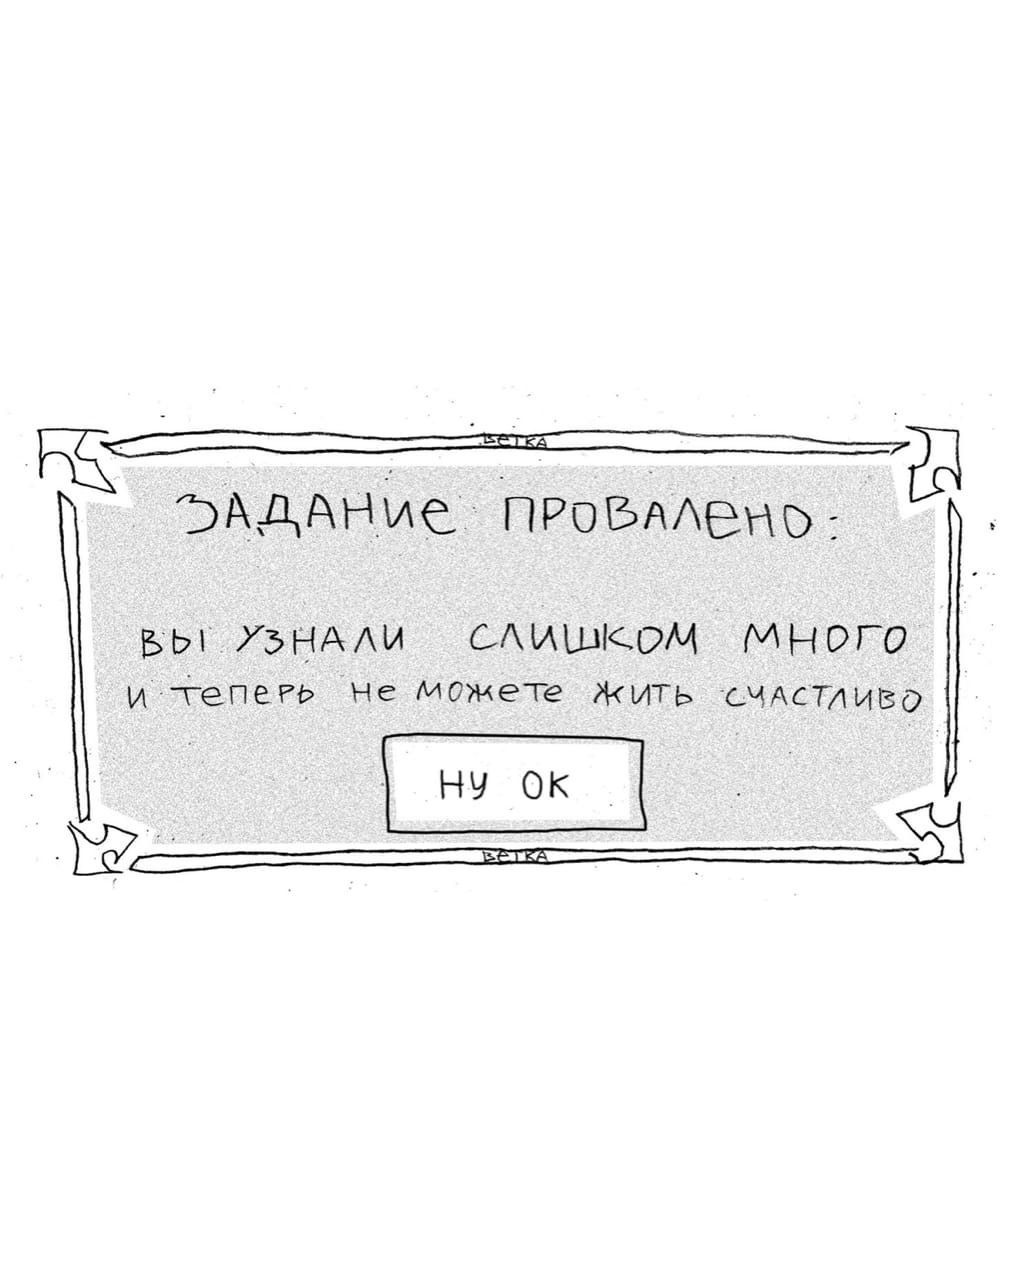

### БОНУС (2.5 баллов)

Градиентный спуск — далеко не единственный метод оптимизации. 
Другой очень известный метод называется ["Алгоритм имитации отжига"](https://ru.wikipedia.org/wiki/%D0%90%D0%BB%D0%B3%D0%BE%D1%80%D0%B8%D1%82%D0%BC_%D0%B8%D0%BC%D0%B8%D1%82%D0%B0%D1%86%D0%B8%D0%B8_%D0%BE%D1%82%D0%B6%D0%B8%D0%B3%D0%B0). Он не так часто используется для оптимизации моделей машинного обучения, но у вас есть уникальная возможность попробовать применить его к нашей любимой линейной регрессии.

**Задание (2.5 баллов)**:
Напишите алгоритм имитации отжига для оптимизации MSE линейной регрессии. 

Сравните результат с градиентным спуском по "траектории" и по финальному лоссу.

Подсказка: каждую новую точку (веса регресси в нашем случае) можно семплировать из некоторого случайного распределением с центром в текущей точке. Хорошо подойдут распределения с "тяжёлыми" хвостами, например, распределение Стьюдента с параметром количества степеней свободы в районе 3.
Это может выглядеть, например, так:
```
new_w = old_w + np.random.standard_t(3, size=old_w.shape)
```
С параметром распределения можно поэксперементировать: чем он больше, тем реже новые точки будут очень сильно уходить от старых.

In [177]:
# -- YOUR CODE HERE --